# Application: `JaxILI` to perform inference on Power Spectrum mock data from `jax_cosmo`

*Author: Sacha Guerrini*

In [85]:
%load_ext autoreload
%autoreload 2

import os
from copy import copy

#import libraries
import warnings
from tqdm import tqdm
from typing import Any, Sequence
warnings.filterwarnings("ignore")

import numpy as np
import scipy.stats as stats
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import jax_cosmo as jc
import haiku as hk
import optuna
import optax

#Tensorflow import
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

#Torch import
import torch
import torch.utils.data as data

#JaxILI import
from jaxili.utils import create_data_loader
from jaxili.model import ConditionalRealNVP, ConditionalMAF, MixtureDensityNetwork
from jaxili.train import TrainerModule, TrainState

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation

In this notebook, we use `jax_cosmo` to simulate $C_l$'s from a power spectrum using a Planck (2015) fiducial cosmology. The goal is here to demonstrate how `jaxili` allows to obtain constraints on the cosmological parameters using the power spectrum in the case of a simple simulator.

In [86]:
cosmo = jc.Planck15() #Create a cosmology with default parameters
cosmo

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

In [87]:
nz = jc.redshift.smail_nz(1., 2., 0.75, gals_per_arcmin2=6)
tracer = jc.probes.WeakLensing([nz])

fiducial_params = np.array([cosmo.Omega_c, cosmo.sigma8])

ell = jnp.logspace(2, np.log10(2000), 20)

#Compute the mean and covariance matrix for this cosology and this tracer
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)

In [88]:
#Let's build a simulator that returns a sample of Cl for a given cosmology
@jax.jit
def sample_likelihood(params, key):
    cosmo = jc.Planck15(Omega_c=params[0], sigma8=params[1])
    mu = jc.angular_cl.angular_cl(cosmo, ell, [tracer]).flatten()
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=jnp.sqrt(jnp.diag(cov)))
    return dist.sample(seed=key)

In [89]:
observation = sample_likelihood(fiducial_params, jax.random.PRNGKey(0))

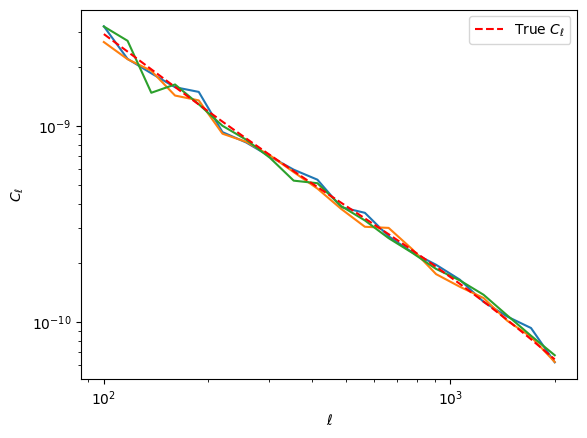

In [90]:
plt.figure()

plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(0)))
plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(1)))
plt.loglog(ell, sample_likelihood(fiducial_params, jax.random.PRNGKey(2)))
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

plt.loglog(ell, mu, color='red', linestyle='--', label="True $C_\ell$")
plt.legend()
plt.show()

Sampling from the covariance allows to recover a noisy vector as output of the simulation which makes the latter stochastic.

In [91]:
seq = hk.PRNGSequence(42)

def simulator(theta):
    return sample_likelihood(theta, next(seq))

In [92]:
#Generate parameters
dim_params = 2
dim_obs = 20

def generate_thetas(n_samples, dim):
    thetas =  stats.qmc.LatinHypercube(d=dim).random(n_samples)
    thetas = stats.qmc.scale(thetas, np.array([0.1, 0.1]), np.array([1, 1]))
    return thetas

In [8]:
class PowerSpectrumDataset(data.Dataset):
    def __init__(self, num_data, dim):
        self.thetas = generate_thetas(num_data, dim)
        self.xs = []
        for theta in self.thetas:
            self.xs.append(simulator(theta))
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

    def set_params(self, thetas):
        self.thetas = thetas
    
    def set_simulation(self, xs):
        self.xs = xs
    
train_set_size = 5000
val_set_size = 1000
test_set_size = 2000

#Create the datasets
train_set = PowerSpectrumDataset(train_set_size, dim_params)
print("Train_set created")
val_set = PowerSpectrumDataset(val_set_size, dim_params)
print("Val_set created")
test_set = PowerSpectrumDataset(test_set_size, dim_params)
print("Test_set created")

#Specify the batch_size
batch_size = 128
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size = 128
)

KeyboardInterrupt: 

In [ ]:
#Save datset
torch.save(train_set, 'ps_dataset/train_set.pt')
torch.save(val_set, 'ps_dataset/val_set.pt')
torch.save(test_set, 'ps_dataset/test_set.pt')

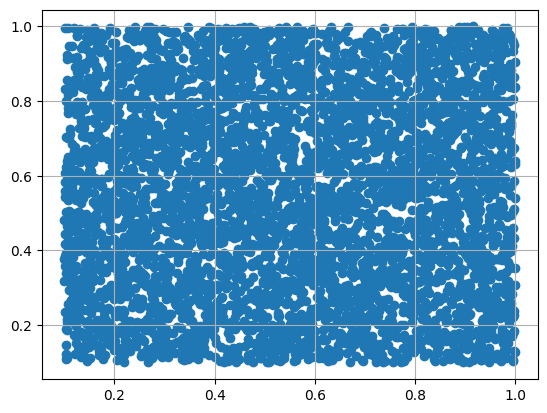

In [79]:
plt.figure()

plt.scatter(train_set.thetas[:, 0], train_set.thetas[:, 1], label="Train set")
plt.grid()
plt.show()

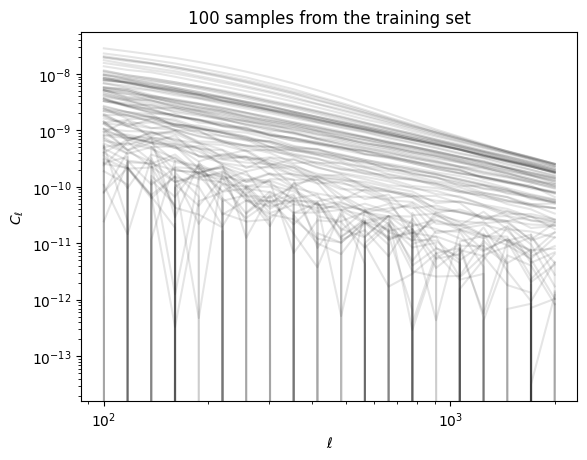

In [80]:
plt.figure()

for sim in train_set.xs[:100]:
    plt.loglog(ell, sim, color='black', alpha=0.1)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("100 samples from the training set")
plt.show()


## Neural Posterior Estimation

We will first perform Neural Posterior Estimation using `JaxILI`. For now, the normalisation of the data is handled by hand. See later updates for automatic renormalisation of the data.

In [93]:
class PowerSpectrumDataset(data.Dataset):
    def __init__(self, num_data, dim):
        self.thetas = generate_thetas(num_data, dim)
        self.xs = []
        for theta in self.thetas:
            self.xs.append(simulator(theta))
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]
    
    def set_params(self, thetas):
        self.thetas = thetas

    def set_simulation(self, xs):
        self.xs = xs

train_set = torch.load('ps_dataset/train_set.pt')
val_set = torch.load('ps_dataset/val_set.pt')
test_set = torch.load('ps_dataset/test_set.pt')

#Normalize the data.
thetas, xs = train_set[:]
xs_mean = xs.mean(axis=0)
xs_std = xs.std(axis=0)
train_set.set_simulation((xs - xs_mean) / xs_std)
_, xs = val_set[:]
val_set.set_simulation((xs - xs_mean) / xs_std)
_, xs = test_set[:]
test_set.set_simulation((xs - xs_mean) / xs_std)

#Specify the batch_size
batch_size = 50
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size = batch_size
)

In [94]:
class MDNTrainer(TrainerModule):#Inherits from TrainerModule to use the training loop
    def __init__(self, #Overload __init__ with hyperparameters of the network
                 n_data : int,
                 n_components : int,
                 layers : Sequence[int],  
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=MixtureDensityNetwork,
                         model_hparams={
                            'n_data': n_data,
                            'n_components': n_components,
                            'layers': layers,
                            'activation': activation
                         },
                         **kwargs)
        self.trial = trial

    def create_functions(self): #The user has to create this function to initialize the train_step and test_step.
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step

    def print_tabulate(self, exmp_input):
         pass
        
    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()
            
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation,
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  method='log_prob')
            return -jnp.mean(output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def generate_config(self, logger_params):
        self.config = {
            'model_class': self.model_class.__name__,
            'model_hparams': copy(self.model_hparams),
            'optimizer_hparams': self.optimizer_hparams,
            'logger_params': logger_params,
            'enable_progress_bar': self.enable_progress_bar,
            'debug': self.debug,
            'check_val_every_epoch': self.check_val_every_epoch,
            'seed': self.seed
        }

    def init_optimizer(self,
                       num_epochs : int,
                       num_steps_per_epoch : int):
        """
        Initializes the optimizer and learning rate scheduler.

        Parameters
        ----------
        num_epochs : Number of epochs to train.
        num_steps_per_epoch : Number of steps per epoch.
        """

        hparams = copy(self.optimizer_hparams)

        #Initialize optimizer
        optimizer_name = hparams.pop('optimizer_name', 'adam')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        else:
            assert False, f'Unknown optimizer \"{optimizer_name}\"'
        #Initialize learning rate scheduler
        #A cosine decay scheduler is used, but others are also possible
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0.1)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        #Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 5.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        #Initialize training state
        self.state = TrainState.create(
            apply_fn=self.state.apply_fn,
            params=self.state.params,
            batch_stats=self.state.batch_stats,
            tx=optimizer,
            rng=self.state.rng
        )
        
    def print_tabulate(self, exmp_input):
        pass

class RealNVPTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_layers : int,
                 layers : list[int],
                 activation : str,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=ConditionalRealNVP,
                         model_hparams={
                             'n_in': n_in,
                             'n_layers': n_layers,
                             'layers' : layers,
                             'activation' : activation
                         },
                         **kwargs)
    
        self.trial=trial
        
    def create_functions(self):
        def loss_nll(params, batch):
            thetas, xs = batch
            return -jnp.mean(self.model.apply({'params': params}, thetas, xs, method='log_prob'))
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch)
            loss, grads =jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = loss_nll(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def run_model_init(self, exmp_input, init_rng):
        return self.model.init(init_rng, *exmp_input, train=True, method='log_prob')
    
    def print_tabulate(self, exmp_input):
        pass

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/loss'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

In [95]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/'

dim_params = 2
dim_obs = 20

trainer = MAFTrainer( #There is some issue with the MAF with an odd number of layers that returns fliped samples.
    n_in=dim_params,
    n_cond=dim_obs,
    n_layers=4,
    layers=[50, 50],
    use_reverse=True,
    seed=30,
    activation='relu',
    optimizer_hparams={
        'lr': 5e-4,
        'optimizer_name': 'adam'
    },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    trial=None,
    debug=False
)

In [96]:
#Let's have a look at the output of the network before training
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, observation.reshape((-1, 20)), num_samples=10000, key=key, method='sample'
)

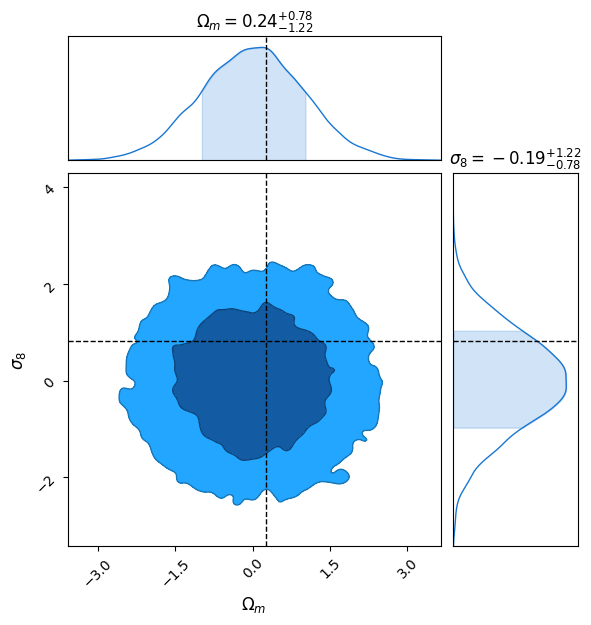

In [97]:
c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()


In [98]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200, patience=20
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_1.orbax-checkpoint-tmp-1710514129488185 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_1
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_1`.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 2
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_2.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_2.orbax-checkpoint-tmp-1710514129880282 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_2
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_2`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_1


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 3
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_3.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_3.orbax-checkpoint-tmp-1710514130270702 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_3
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_3`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 4
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_4.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_4.orbax-checkpoint-tmp-1710514130654381 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_4
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_4`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_3


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 5
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_5.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_5.orbax-checkpoint-tmp-1710514131056915 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_5
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_5`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_4


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 6
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_6.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_6.orbax-checkpoint-tmp-1710514131424332 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_6
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_6`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 7
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_7.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_7.orbax-checkpoint-tmp-1710514131849237 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_7
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_7`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_6


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 9
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_9.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_9.orbax-checkpoint-tmp-1710514132614594 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_9
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_9`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_7


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 10
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_10.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_10.orbax-checkpoint-tmp-1710514133017367 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_10
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_10`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_9


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 11
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_11.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_11.orbax-checkpoint-tmp-1710514133401270 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_11
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_11`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_10


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 13
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_13.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_13.orbax-checkpoint-tmp-1710514134155950 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_13
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_13`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_11


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 14
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_14.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_14.orbax-checkpoint-tmp-1710514134538641 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_14
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_14`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_13


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 16
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_16.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_16.orbax-checkpoint-tmp-1710514135237976 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_16
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_16`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_14


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 17
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_17.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_17.orbax-checkpoint-tmp-1710514135572899 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_17
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_17`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_16


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 21
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_21.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_21.orbax-checkpoint-tmp-1710514136963262 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_21
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_21`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_17


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 22
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_22.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_22.orbax-checkpoint-tmp-1710514137331650 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_22
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_22`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_21


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 24
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_24.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_24.orbax-checkpoint-tmp-1710514138057610 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_24
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_24`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_22


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 27
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_27.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_27.orbax-checkpoint-tmp-1710514139158957 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_27
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_27`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_24


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 28
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_28.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_28.orbax-checkpoint-tmp-1710514139526225 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_28
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_28`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_27


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 31
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_31.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_31.orbax-checkpoint-tmp-1710514140612493 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_31
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_31`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_28


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 34
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_34.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_34.orbax-checkpoint-tmp-1710514141642590 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_34
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_34`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_31


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 35
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_35.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_35.orbax-checkpoint-tmp-1710514142042570 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_35
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_35`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_34


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 37
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_37.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_37.orbax-checkpoint-tmp-1710514142853074 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_37
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_37`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_35


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 44
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_44.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_44.orbax-checkpoint-tmp-1710514145386681 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_44
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_44`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_37


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 45
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_45.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_45.orbax-checkpoint-tmp-1710514145745393 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_45
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_45`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_44


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 52
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_52.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_52.orbax-checkpoint-tmp-1710514148320396 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_52
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_52`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_45


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 60
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_60.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_60.orbax-checkpoint-tmp-1710514150954814 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_60
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_60`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_52


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 66
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_66.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_66.orbax-checkpoint-tmp-1710514152936956 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_66
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_66`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_60


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 68
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_68.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_68.orbax-checkpoint-tmp-1710514153588913 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_68
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_68`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_66


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 78
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_78.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_78.orbax-checkpoint-tmp-1710514157256329 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_78
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_78`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_68


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 79
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_79.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_79.orbax-checkpoint-tmp-1710514157666977 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_79
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_79`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_78


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 87
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_87.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_87.orbax-checkpoint-tmp-1710514160315944 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_87
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_87`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_79


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 89
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_89.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_89.orbax-checkpoint-tmp-1710514161008545 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_89
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_89`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_87


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 91
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_91.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_91.orbax-checkpoint-tmp-1710514161663516 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_91
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_91`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_89


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 97
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_97.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_97.orbax-checkpoint-tmp-1710514163806086 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_97
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_97`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_91


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 102
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_102.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_102.orbax-checkpoint-tmp-1710514165839488 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_102
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_102`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_97


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 112
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_112.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_112.orbax-checkpoint-tmp-1710514170193943 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_112
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_112`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_102


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 126
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_126.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_126.orbax-checkpoint-tmp-1710514175036351 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_126
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_126`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_112


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 130
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_130.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_130.orbax-checkpoint-tmp-1710514176426409 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_130
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_130`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_126


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 134
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_134.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_134.orbax-checkpoint-tmp-1710514177789921 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_134
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_134`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_130


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 135
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_135.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_135.orbax-checkpoint-tmp-1710514178125008 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_135
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_135`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_134


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 145
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_145.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_145.orbax-checkpoint-tmp-1710514181443598 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_145
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_145`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_135


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 150
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_150.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_150.orbax-checkpoint-tmp-1710514183130073 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_150
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_150`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_145


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 151
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_151.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_151.orbax-checkpoint-tmp-1710514183528125 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_151
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_151`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_150


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 160
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_160.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_160.orbax-checkpoint-tmp-1710514186431537 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_160
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_160`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_151


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 165
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_165.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_165.orbax-checkpoint-tmp-1710514188100679 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_165
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_165`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_160


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 168
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_168.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_168.orbax-checkpoint-tmp-1710514189165909 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_168
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_168`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_165


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 185
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_185.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_185.orbax-checkpoint-tmp-1710514195513218 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_185
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_185`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_168


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 186
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_186.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_186.orbax-checkpoint-tmp-1710514195843264 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_186
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_186`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_185


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 187
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_187.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_187.orbax-checkpoint-tmp-1710514196175587 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_187
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_187`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_186


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 194
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_194.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_194.orbax-checkpoint-tmp-1710514198408530 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_194
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_194`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_187


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Restoring orbax checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_194
INFO:absl:Restoring item from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_194.
INFO:absl:Finished restoring checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalMAF/version_22/checkpoint_194.


In [99]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -3.7171905040740967
Validation loss: -3.6592752933502197
Test loss: -3.717325448989868


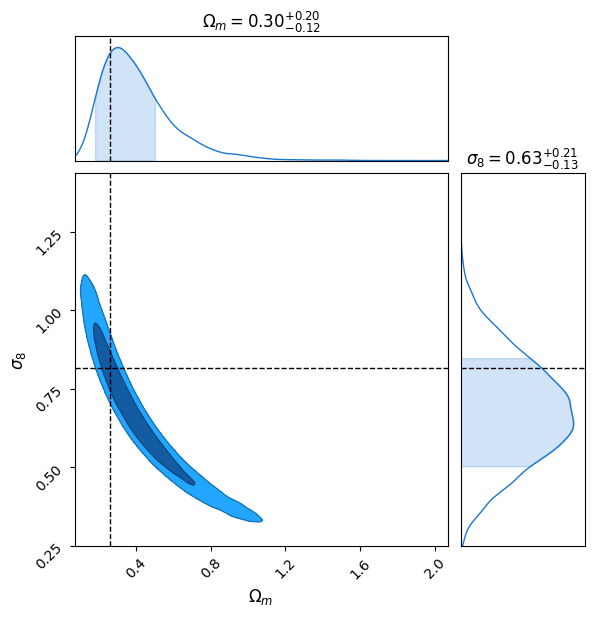

In [100]:
model = trainer.bind_model()

#Let's have a look at the output of the network after training
key = jax.random.PRNGKey(0)
samples_maf = model.sample(
    (observation.reshape((-1, 20))-xs_mean)/xs_std, num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(samples_maf, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()

In [101]:
log_prob = model.log_prob(samples_maf, (observation.reshape((-1, 20))-xs_mean)/xs_std*jnp.ones((10000, 1)))

In [102]:
print(f"Loss: {-jnp.mean(log_prob):.3f}" )

Loss: -4.496


We can also to try to use other architectures such the `ConditionalRealNVP` or the `MixtureDensityNetwork`.

In [103]:
trainer = RealNVPTrainer(n_in=dim_params,
                         n_layers=4,
                        layers=[50, 50],
                        activation = 'silu',
                        optimizer_hparams={'lr': 5e-4},
                        logger_params={'base_log_dir': CHECKPOINT_PATH},
                        exmp_input=next(iter(train_loader)),
                        check_val_every_epoch=1,
                        seed=0)

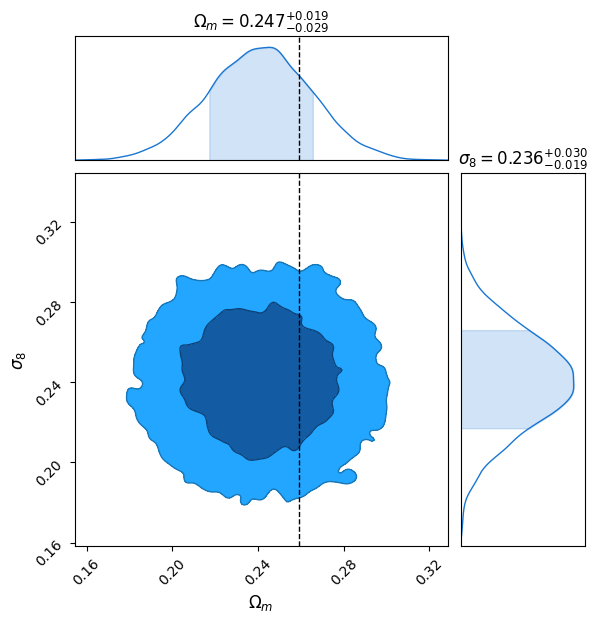

In [104]:
#Let's have a look at the output of the network before training
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, (observation.reshape((-1, 20))-xs_mean)/xs_std, num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()


In [105]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200, patience=20
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_1.orbax-checkpoint-tmp-1710514207265075 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_1
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_1`.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 2
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_2.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_2.orbax-checkpoint-tmp-1710514207689787 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_2
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_2`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_1


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 3
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_3.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_3.orbax-checkpoint-tmp-1710514208053016 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_3
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_3`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 4
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_4.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_4.orbax-checkpoint-tmp-1710514208416428 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_4
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_4`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_3


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 6
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_6.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_6.orbax-checkpoint-tmp-1710514209191692 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_6
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_6`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_4


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 7
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_7.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_7.orbax-checkpoint-tmp-1710514209573158 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_7
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_7`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_6


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 8
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_8.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_8.orbax-checkpoint-tmp-1710514209936983 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_8
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_8`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_7


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 11
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_11.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_11.orbax-checkpoint-tmp-1710514211067856 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_11
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_11`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_8


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 12
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_12.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_12.orbax-checkpoint-tmp-1710514211456072 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_12
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_12`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_11


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 13
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_13.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_13.orbax-checkpoint-tmp-1710514211864043 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_13
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_13`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_12


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 20
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_20.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_20.orbax-checkpoint-tmp-1710514214382570 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_20
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_20`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_13


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 21
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_21.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_21.orbax-checkpoint-tmp-1710514214800934 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_21
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_21`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_20


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 24
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_24.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_24.orbax-checkpoint-tmp-1710514215941770 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_24
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_24`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_21


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 26
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_26.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_26.orbax-checkpoint-tmp-1710514216705268 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_26
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_26`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_24


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 28
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_28.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_28.orbax-checkpoint-tmp-1710514217446274 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_28
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_28`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_26


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 31
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_31.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_31.orbax-checkpoint-tmp-1710514218591221 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_31
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_31`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_28


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 32
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_32.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_32.orbax-checkpoint-tmp-1710514218974835 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_32
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_32`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_31


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 36
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_36.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_36.orbax-checkpoint-tmp-1710514220477201 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_36
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_36`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_32


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 38
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_38.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_38.orbax-checkpoint-tmp-1710514221201751 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_38
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_38`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_36


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 41
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_41.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_41.orbax-checkpoint-tmp-1710514222451200 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_41
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_41`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_38


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 45
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_45.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_45.orbax-checkpoint-tmp-1710514224003580 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_45
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_45`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_41


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 48
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_48.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_48.orbax-checkpoint-tmp-1710514225219001 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_48
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_48`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_45


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 54
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_54.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_54.orbax-checkpoint-tmp-1710514227453206 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_54
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_54`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_48


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 56
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_56.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_56.orbax-checkpoint-tmp-1710514228244766 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_56
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_56`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_54


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 57
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_57.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_57.orbax-checkpoint-tmp-1710514228626686 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_57
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_57`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_56


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 60
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_60.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_60.orbax-checkpoint-tmp-1710514229749298 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_60
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_60`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_57


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 62
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_62.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_62.orbax-checkpoint-tmp-1710514230458628 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_62
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_62`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_60


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 65
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_65.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_65.orbax-checkpoint-tmp-1710514231609768 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_65
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_65`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_62


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 68
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_68.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_68.orbax-checkpoint-tmp-1710514232733965 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_68
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_68`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_65


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 69
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_69.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_69.orbax-checkpoint-tmp-1710514233122598 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_69
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_69`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_68


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 76
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_76.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_76.orbax-checkpoint-tmp-1710514235810912 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_76
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_76`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_69


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 77
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_77.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_77.orbax-checkpoint-tmp-1710514236184514 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_77
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_77`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_76


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 78
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_78.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_78.orbax-checkpoint-tmp-1710514236545071 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_78
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_78`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_77


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 80
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_80.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_80.orbax-checkpoint-tmp-1710514237332920 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_80
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_80`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_78


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 82
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_82.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_82.orbax-checkpoint-tmp-1710514238079350 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_82
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_82`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_80


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 83
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_83.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_83.orbax-checkpoint-tmp-1710514238499739 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_83
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_83`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_82


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 84
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_84.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_84.orbax-checkpoint-tmp-1710514238877206 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_84
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_84`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_83


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 88
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_88.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_88.orbax-checkpoint-tmp-1710514240316647 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_88
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_88`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_84


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 95
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_95.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_95.orbax-checkpoint-tmp-1710514243012314 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_95
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_95`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_88


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 101
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_101.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_101.orbax-checkpoint-tmp-1710514245287781 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_101
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_101`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_95


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 103
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_103.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_103.orbax-checkpoint-tmp-1710514246014709 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_103
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_103`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_101


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 108
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_108.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_108.orbax-checkpoint-tmp-1710514247915669 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_108
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_108`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_103


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 110
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_110.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_110.orbax-checkpoint-tmp-1710514248703816 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_110
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_110`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_108


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 113
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_113.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_113.orbax-checkpoint-tmp-1710514249762468 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_113
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_113`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_110


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 117
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_117.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_117.orbax-checkpoint-tmp-1710514251333534 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_117
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_117`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_113


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 118
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_118.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_118.orbax-checkpoint-tmp-1710514251746047 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_118
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_118`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_117


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 131
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_131.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_131.orbax-checkpoint-tmp-1710514256578759 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_131
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_131`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_118


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 132
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_132.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_132.orbax-checkpoint-tmp-1710514256944089 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_132
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_132`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_131


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 142
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_142.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_142.orbax-checkpoint-tmp-1710514260675402 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_142
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_142`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_132


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 152
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_152.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_152.orbax-checkpoint-tmp-1710514264396219 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_152
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_152`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_142


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 162
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_162.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_162.orbax-checkpoint-tmp-1710514268003123 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_162
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_162`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_152


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 168
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_168.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_168.orbax-checkpoint-tmp-1710514270181677 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_168
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_168`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_162


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 171
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_171.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_171.orbax-checkpoint-tmp-1710514271346564 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_171
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_171`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_168


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 175
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_175.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_175.orbax-checkpoint-tmp-1710514272784918 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_175
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_175`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_171


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 179
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_179.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_179.orbax-checkpoint-tmp-1710514274271251 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_179
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_179`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_175


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 185
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_185.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_185.orbax-checkpoint-tmp-1710514276511822 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_185
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_185`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_179


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 191
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_191.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_191.orbax-checkpoint-tmp-1710514278781858 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_191
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_191`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_185


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 192
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_192.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_192.orbax-checkpoint-tmp-1710514279201220 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_192
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_192`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_191


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 193
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_193.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_193.orbax-checkpoint-tmp-1710514279580793 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_193
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_193`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_192


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Restoring orbax checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_193
INFO:absl:Restoring item from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_193.
INFO:absl:Finished restoring checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/ConditionalRealNVP/version_8/checkpoint_193.


In [106]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -4.195718288421631
Validation loss: -4.140244483947754
Test loss: -4.163788318634033


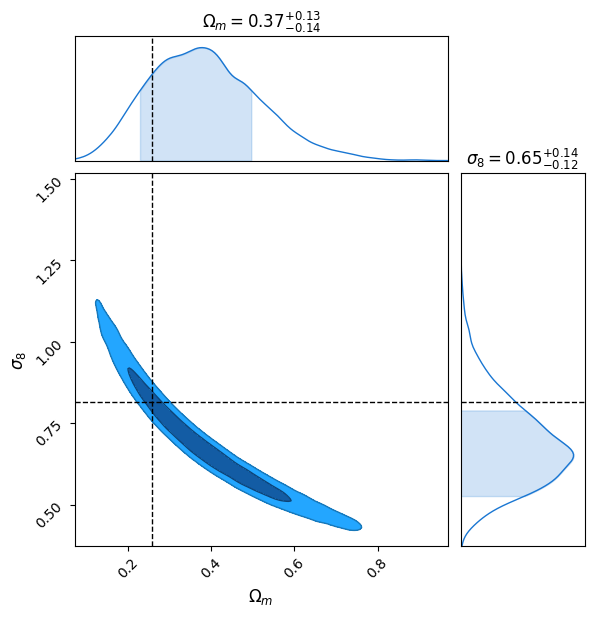

In [107]:
model = trainer.bind_model()

#Let's have a look at the output of the network after training
key = jax.random.PRNGKey(0)
samples_rnvp = model.sample(
    (observation.reshape((-1, 20))-xs_mean)/xs_std, num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(samples_rnvp, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()

In [108]:
trainer = MDNTrainer(n_data=dim_params, #Create your trainer
                            n_components=4,
                            layers=[128, 128],
                            activation='silu',
                            optimizer_hparams={'lr': 5e-4},
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(train_loader)), #beware of the training input.
                            check_val_every_epoch=5
                            )

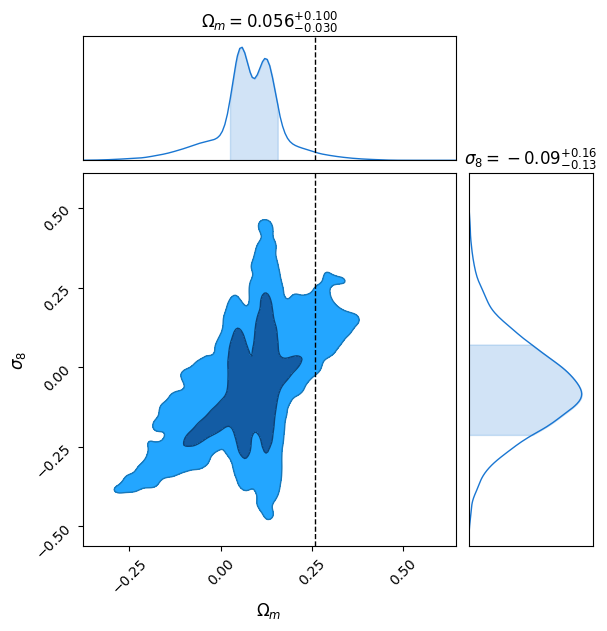

In [109]:
#Let's have a look at the output of the network before training
key = jax.random.PRNGKey(0)
samples = trainer.model.apply(
    {'params': trainer.state.params}, (observation.reshape((-1, 20))-xs_mean)/xs_std, num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()

In [110]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200, patience=20
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 5
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_5.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_5.orbax-checkpoint-tmp-1710514285346519 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_5
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_5`.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 10
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_10.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_10.orbax-checkpoint-tmp-1710514286061295 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_10
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_10`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 20
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_20.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_20.orbax-checkpoint-tmp-1710514287345090 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_20
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_20`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_10


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 25
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_25.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_25.orbax-checkpoint-tmp-1710514287959583 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_25
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_25`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_20


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 30
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_30.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_30.orbax-checkpoint-tmp-1710514288701253 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_30
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_30`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_25


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 40
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_40.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_40.orbax-checkpoint-tmp-1710514289842042 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_40
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_40`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_30


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 45
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_45.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_45.orbax-checkpoint-tmp-1710514290442009 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_45
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_45`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_40


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 50
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_50.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_50.orbax-checkpoint-tmp-1710514291083656 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_50
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_50`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_45


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 55
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_55.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_55.orbax-checkpoint-tmp-1710514291654307 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_55
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_55`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_50


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 60
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_60.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_60.orbax-checkpoint-tmp-1710514292260303 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_60
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_60`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_55


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 75
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_75.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_75.orbax-checkpoint-tmp-1710514294042201 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_75
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_75`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_60


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 90
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_90.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_90.orbax-checkpoint-tmp-1710514295851280 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_90
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_90`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_75


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 105
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_105.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_105.orbax-checkpoint-tmp-1710514297720978 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_105
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_105`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_90


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 110
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_110.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_110.orbax-checkpoint-tmp-1710514298345778 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_110
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_110`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_105


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 120
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_120.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_120.orbax-checkpoint-tmp-1710514299471036 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_120
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_120`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_110


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 135
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_135.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_135.orbax-checkpoint-tmp-1710514301220133 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_135
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_135`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_120


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 140
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_140.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_140.orbax-checkpoint-tmp-1710514301852476 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_140
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_140`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_135


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 155
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_155.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_155.orbax-checkpoint-tmp-1710514303582946 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_155
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_155`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_140


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 165
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_165.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_165.orbax-checkpoint-tmp-1710514304773555 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_165
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_165`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_155


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 180
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_180.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_180.orbax-checkpoint-tmp-1710514306545337 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_180
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_180`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_165


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 185
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_185.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_185.orbax-checkpoint-tmp-1710514307116786 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_185
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_185`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_180


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 195
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_195.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_195.orbax-checkpoint-tmp-1710514308327070 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_195
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_195`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_185


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Restoring orbax checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_195
INFO:absl:Restoring item from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_195.
INFO:absl:Finished restoring checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_ps/MixtureDensityNetwork/version_11/checkpoint_195.


In [111]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: -3.8096423149108887
Validation loss: -3.744830369949341
Test loss: -3.687321662902832


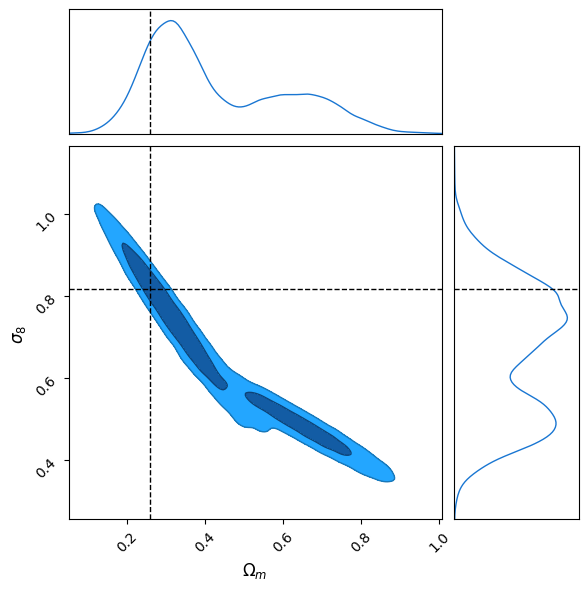

In [112]:
model = trainer.bind_model()

#Let's have a look at the output of the network after training
key = jax.random.PRNGKey(0)
samples_mdn = model.sample(
    (observation.reshape((-1, 20))-xs_mean)/xs_std, num_samples=10000, key=key
)

c = ChainConsumer()
c.add_chain(samples_mdn, parameters=[r"$\Omega_m$", r"$\sigma_8$"])
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()

Let's finally compare the constraints obtained with the different architectures:

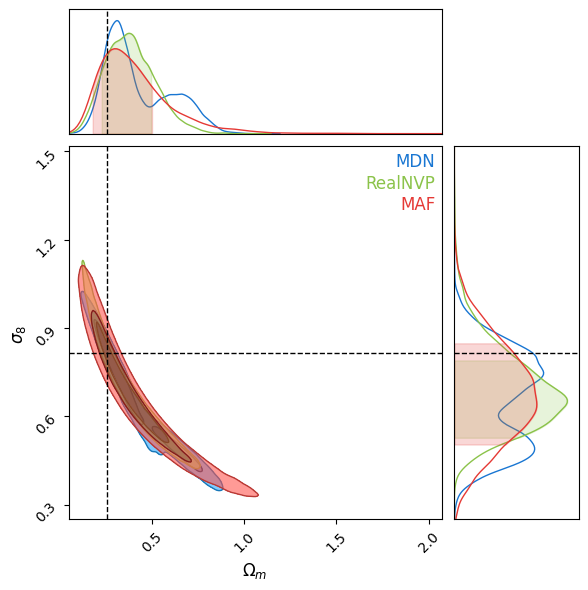

In [113]:
c = ChainConsumer()
c.add_chain(samples_mdn, parameters=[r"$\Omega_m$", r"$\sigma_8$"], name="MDN")
c.add_chain(samples_rnvp, parameters=[r"$\Omega_m$", r"$\sigma_8$"], name="RealNVP")
c.add_chain(samples_maf, parameters=[r"$\Omega_m$", r"$\sigma_8$"], name="MAF")
fig = c.plotter.plot(figsize=2., truth=fiducial_params)
plt.show()